# 뉴스 기사 분류

## 로이터 데이터셋

In [59]:
## 로이터 데이터셋 로드하기
# 1986년 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합
# 텍스트 분류의 대표적인 데이터셋. 46개의 토픽. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있다.
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
# IMDB 데이터셋에서처럼 num_words=10000 매개변수는 10,000개로 제한한다.

In [60]:
# 8,982개의 훈련 샘플
len(train_data)

8982

In [61]:
# 2,246개의 테스트 샘플
len(test_data)

2246

In [62]:
train_data[10] # 각 샘플은 정수 리스트 (단어 인덱스)

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [63]:
# 로이터 데이터셋을 텍스트로 디코딩하기
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]]) # 0,1,2는'패딩','문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺀다.

In [64]:
train_labels[10]
# 샘플에 연결된 레이블은 토픽의 인덱스로 0과 45 사이의 정수

3

In [65]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## 데이터 준비

In [32]:
# 데이터 인코딩 - 벡터로 변환
# 첫번째 방법 : 레이블의 리스트를 정수 텐서로 변환하는 것
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_data) # 훈련 데이터 변환
x_test = vectorize_sequences(test_data) # 테스트 데이터 변환

In [33]:
# 두번째 방법 : 원-핫 인코딩
# 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩이라고도 부른다.
# 각 레이블의 인덱스 자리는 1이고 나머지는 0인 벡터
def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

one_hot_train_labels = to_one_hot(train_labels) # 훈련 레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels) # 테스트 레이블 벡터 변환

In [34]:
# 케라스에는 이를 위한 내장 함수가 있다.
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [35]:
one_hot_test_labels[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [36]:
len(one_hot_test_labels[0])

46

## 모델 구성

`Dense` 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있습니다. 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없습니다. 각 층은 잠재적으로 정보의 병목이 될 수 있습니다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 너무 제약이 많을 것 같습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 동작할 수 있습니다.

이런 이유로 좀 더 규모가 큰 층을 사용하겠습니다. 64개의 유닛을 사용해 보죠.

In [37]:
# 모델 정의
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

이 구조에서 주목해야 할 점이 두 가지 있습니다:

* 마지막 `Dense` 층의 크기가 46입니다. 각 입력 샘플에 대해서 46차원의 벡터를 출력한다는 뜻입니다. 이 벡터의 각 원소(각 차원)은 각기 다른 출력 클래스가 인코딩된 것입니다.
* 마지막 층에 `softmax` 활성화 함수가 사용되었습니다. MNIST 예제에서 이런 방식을 보았습니다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력합니다. 즉, 46차원의 출력 벡터를 만들며 `output[i]`는 어떤 샘플이 클래스 `i`에 속할 확률입니다. 46개의 값을 모두 더하면 1이 됩니다.

이런 문제에 사용할 최선의 손실 함수는 `categorical_crossentropy`입니다. 이 함수는 두 확률 분포의 사이의 거리를 측정합니다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리입니다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 됩니다.

In [38]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 훈련 검증

In [39]:
# 훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트 준비.
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [40]:
# 20번의 에포크로 모델 훈련.
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val,y_val))


Epoch 1/20
16/16 [==============================] - 2s 78ms/step - loss: 2.4515 - accuracy: 0.4856 - val_loss: 1.6415 - val_accuracy: 0.6400
Epoch 2/20
16/16 [==============================] - 1s 64ms/step - loss: 1.3651 - accuracy: 0.7126 - val_loss: 1.2929 - val_accuracy: 0.7260
Epoch 3/20
16/16 [==============================] - 1s 61ms/step - loss: 1.0273 - accuracy: 0.7886 - val_loss: 1.1102 - val_accuracy: 0.7660
Epoch 4/20
16/16 [==============================] - 1s 61ms/step - loss: 0.8092 - accuracy: 0.8316 - val_loss: 1.0131 - val_accuracy: 0.7790
Epoch 5/20
16/16 [==============================] - 1s 59ms/step - loss: 0.6447 - accuracy: 0.8692 - val_loss: 0.9581 - val_accuracy: 0.7880
Epoch 6/20
16/16 [==============================] - 1s 62ms/step - loss: 0.5124 - accuracy: 0.8908 - val_loss: 0.9125 - val_accuracy: 0.8070
Epoch 7/20
16/16 [==============================] - 1s 58ms/step - loss: 0.4116 - accuracy: 0.9138 - val_loss: 0.8703 - val_accuracy: 0.8110
Epoch 8/20
16

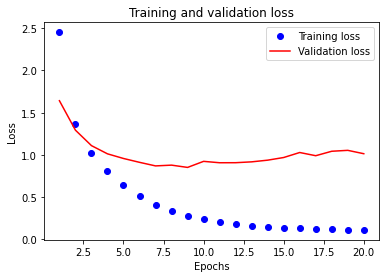

In [41]:
# 훈련과 검증 데이터에 대한 손실 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

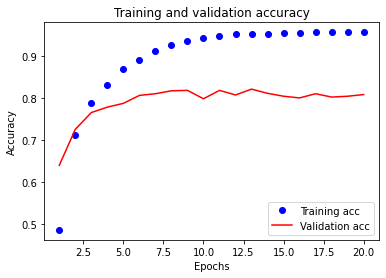

In [56]:
# 훈련과 검증 데이터에 대한 정확도 그리기
plt.clf() # 그래프 초기화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 9번째 에포크 이후에 과대적합이 시작됩니다. 9번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가하겠습니다.

In [45]:
# 모델을 처음부터 다시 훈련하기
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 4s 112ms/step - loss: 2.6653 - accuracy: 0.4643 - val_loss: 1.8413 - val_accuracy: 0.6170
Epoch 2/9
16/16 [==============================] - 1s 66ms/step - loss: 1.5011 - accuracy: 0.6833 - val_loss: 1.3672 - val_accuracy: 0.7060
Epoch 3/9
16/16 [==============================] - 1s 69ms/step - loss: 1.0964 - accuracy: 0.7696 - val_loss: 1.1572 - val_accuracy: 0.7480
Epoch 4/9
16/16 [==============================] - 2s 135ms/step - loss: 0.8537 - accuracy: 0.8213 - val_loss: 1.0335 - val_accuracy: 0.7890
Epoch 5/9
16/16 [==============================] - 2s 152ms/step - loss: 0.6758 - accuracy: 0.8621 - val_loss: 0.9959 - val_accuracy: 0.7990
Epoch 6/9
16/16 [==============================] - 2s 126ms/step - loss: 0.5372 - accuracy: 0.8919 - val_loss: 0.9463 - val_accuracy: 0.7950
Epoch 7/9
16/16 [==============================] - 2s 107ms/step - loss: 0.4351 - accuracy: 0.9133 - val_loss: 0.9067 - val_accuracy: 0.8240
Epoch 8/9
16/16

In [46]:
# 대략 78% 정확도
results

[1.0148215293884277, 0.7707034945487976]

In [47]:
# 무작위로 분류하면 18% 정확도 
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels)==np.array(test_labels_copy)
float(np.sum(hits_array))/len(test_labels)

0.19456812110418523

균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성합니다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 19% 정도를 달성합니다. 여기에 비하면 이 결과는 꽤 좋은 편입니다.

## 새로운 데이터에 대해 예측하기

모델 인스턴스의 `predict` 메서드는 46개 토픽에 대한 확률 분포를 반환합니다. 테스트 데이터 전체에 대한 토픽을 예측해 보겠습니다.

In [48]:
# 새로운 데이터에 대해 예측하기
predictions = model.predict(x_test)

71/71 [==============================] - 1s 5ms/step


In [49]:
predictions

array([[2.4540148e-05, 1.2720199e-04, 6.1436904e-06, ..., 4.3613865e-05,
        1.1750670e-06, 2.1906909e-07],
       [7.8252633e-06, 1.2964477e-03, 8.5471307e-05, ..., 1.5512156e-06,
        4.1516007e-08, 1.2460492e-06],
       [1.2871632e-02, 7.3961723e-01, 4.0160548e-03, ..., 7.3567487e-04,
        2.8394689e-04, 3.0177255e-04],
       ...,
       [3.2438831e-05, 3.9513648e-04, 3.5257919e-05, ..., 5.8767710e-05,
        3.0243320e-05, 7.0726164e-06],
       [5.4616667e-04, 4.3130551e-02, 1.0195799e-03, ..., 9.1276184e-04,
        3.3684712e-05, 3.8109003e-05],
       [2.9410905e-04, 7.2449666e-01, 1.8175495e-03, ..., 2.4319666e-04,
        8.2315732e-05, 6.5411878e-05]], dtype=float32)

In [50]:
predictions[0].shape
# `predictions`의 각 항목은 길이가 46인 벡터

(46,)

In [51]:
np.sum(predictions[0])
# 이 벡터의 원소 합은 1

1.0

In [66]:
np.argmax(predictions[0])
# 가장 큰 값이 예측 클래스가 된다. 즉, 가장 확률이 높은 클래스이다.

4

## 레이블과 손실을 다루는 다른 방법

앞서 언급한 것처럼 레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것입니다.

In [67]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

이 방식을 사용하려면 손실 함수 하나만 바꾸면 됩니다. 코드 3-21에 사용된 손실 함수 `categorical_crossentropy`는 레이블이 범주형 인코딩되어 있을 것이라고 기대합니다. 정수 레이블을 사용할 때는 `sparse_categorical_crossentropy`를 사용해야 합니다.

In [68]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

## 충분히 큰 중간층을 두어아 하는 이유
마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 됩니다. 46차원보다 훨씬 작은 중간층(예를 들면 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.

In [57]:
# 정보 병목이 있는 모델
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data = (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 4s 27ms/step - loss: 3.0759 - accuracy: 0.1701 - val_loss: 2.4777 - val_accuracy: 0.2570
Epoch 2/20
63/63 [==============================] - 1s 24ms/step - loss: 2.0845 - accuracy: 0.3592 - val_loss: 1.8433 - val_accuracy: 0.4370
Epoch 3/20
63/63 [==============================] - 2s 30ms/step - loss: 1.5945 - accuracy: 0.5550 - val_loss: 1.5370 - val_accuracy: 0.6430
Epoch 4/20
63/63 [==============================] - 2s 37ms/step - loss: 1.3033 - accuracy: 0.6885 - val_loss: 1.4082 - val_accuracy: 0.6810
Epoch 5/20
63/63 [==============================] - 1s 22ms/step - loss: 1.1467 - accuracy: 0.7147 - val_loss: 1.3427 - val_accuracy: 0.6940
Epoch 6/20
63/63 [==============================] - 1s 22ms/step - loss: 1.0253 - accuracy: 0.7359 - val_loss: 1.3134 - val_accuracy: 0.6990
Epoch 7/20
63/63 [==============================] - 1s 23ms/step - loss: 0.9271 - accuracy: 0.7643 - val_loss: 1.3317 - val_accuracy: 0.7010
Epoch 8/20
63

검증 정확도의 최고 값은 약 71%로 8% 정도 감소되었습니다. 이런 손실의 대부분 원인은 많은 정보(46개 클래스의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문입니다. 이 네트워크는 필요한 정보 대부분을 4차원 표현 안에 구겨 넣었지만 전부는 넣지 못했습니다.